# 3.2 线性回归的从零开始实现

In [2]:
%matplotlib inline
import torch
from matplotlib import pyplot as plt
import random

## 生成数据集

In [3]:
def synthetic_data(w, b, num_examples):
    """生成y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) #(1000, 2)
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print(features[0], labels[0])

tensor([0.4359, 1.0552]) tensor([1.4911])


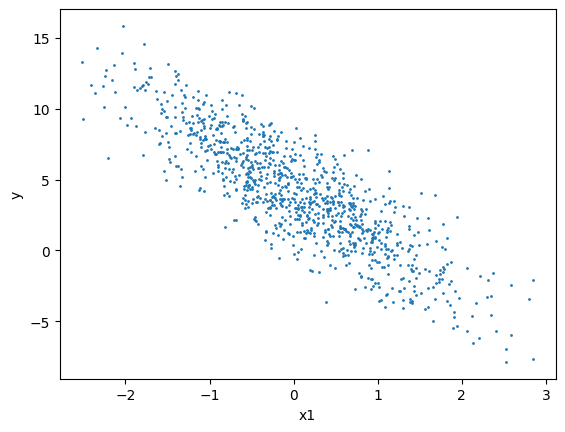

In [5]:
def plot(features, labels):
    plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.show()
plot(features, labels)

## Data Loader

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.3642,  1.0893],
        [ 0.2584,  1.2290],
        [-2.3347,  0.0442],
        [ 0.2745,  2.3494],
        [ 0.0849,  0.7584],
        [-0.0316,  0.4020],
        [-0.1827, -0.6073],
        [-2.0835,  1.0372],
        [ 1.3782,  0.9692],
        [-0.8156, -0.8566]]) 
 tensor([[-0.2334],
        [ 0.5216],
        [-0.6102],
        [-3.2408],
        [ 1.7861],
        [ 2.7587],
        [ 5.8863],
        [-3.4993],
        [ 3.6540],
        [ 5.4878]])


## Model

In [8]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

## Loss Function

In [9]:
def squared_loss(y_hat, y):
    """均方损失
    计算预测值y_hat和真实标签y之间的均方损失
    Args:
        y_hat (_type_): shape:(batch_size, 1)
        y (_type_): shape:(batch_size, )
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Gradient Descent (mini-batch SGD)



In [10]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param.data -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
w = torch.normal(0, 0.01, size=(2, 1),requires_grad=True) # shape:(features_num, 1)
b = torch.zeros(1, requires_grad=True)
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失 (batch_size, 1); 不是一个标量, 需要求和
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    # inference
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.047629
epoch 2, loss 0.000205
epoch 3, loss 0.000047


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0015], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0012], grad_fn=<RsubBackward1>)


## PyTorch implementation

In [13]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器
    Args:
        data_arrays (_type_): 包含特征和标签的列表
        batch_size (_type_): 批量大小
        is_train (bool, optional): 是否为训练集. Defaults to True.
    """
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.4094,  0.0864],
         [-0.7930,  0.3778],
         [ 0.3958,  0.3087],
         [ 0.2867, -0.6061],
         [ 0.4321, -0.0355],
         [-0.2069, -0.5359],
         [-0.0316,  0.4020],
         [-2.1946, -1.5182],
         [-0.3408, -1.4100],
         [ 0.9264, -1.1658]]),
 tensor([[ 3.0834],
         [ 1.3294],
         [ 3.9497],
         [ 6.8431],
         [ 5.1947],
         [ 5.6000],
         [ 2.7587],
         [ 4.9702],
         [ 8.3088],
         [10.0181]])]

## Model

In [16]:
import torch.nn as nn

net = nn.Sequential(nn.Linear(2, 1)) # regression model
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Training

In [17]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    with torch.no_grad():
        train_l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000345
epoch 2, loss 0.000094
epoch 3, loss 0.000094


In [18]:
w = net[0].weight.data
b = net[0].bias.data
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0007, -0.0007])
b的估计误差: tensor([0.0010])
